In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"upadhyayroshan","key":"0549699db6f2d465b7b5794ac37a2262"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:09<00:00, 263MB/s]
100% 2.29G/2.29G [00:09<00:00, 250MB/s]


In [5]:
from zipfile import ZipFile
file_name = 'chest-xray-pneumonia.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [7]:
os.listdir('/content/chest_xray')

['__MACOSX', 'train', 'chest_xray', 'test', 'val']

In [8]:
import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image

In [9]:
def load_imgs(impath):
    imgs=[]
    label=[]
    l1=os.listdir(impath)
    for i in l1:
        l2=os.listdir(impath+'/'+i)
        for j in l2:
            c=0
            img=Image.open(impath+i+'/'+j).convert('RGB')
            img=img.resize(size=(100,100))
             #img=img.convert('L')
            img=np.array(img,dtype=np.float16)/255
            imgs.append(np.array(img)) #.flatten())
            label.append(i)
            #del img
            '''if(c%1000==0):
                plt.imshow(img)
                plt.show()
                c=c+1'''
            del img
    return np.array(imgs),label

In [10]:
x_train,y_train=load_imgs('/content/chest_xray/train/')
x_train.shape,len(y_train)

((5216, 100, 100, 3), 5216)

In [11]:
target=pd.Series(y_train,dtype='category')
target

0          NORMAL
1          NORMAL
2          NORMAL
3          NORMAL
4          NORMAL
          ...    
5211    PNEUMONIA
5212    PNEUMONIA
5213    PNEUMONIA
5214    PNEUMONIA
5215    PNEUMONIA
Length: 5216, dtype: category
Categories (2, object): ['NORMAL', 'PNEUMONIA']

In [12]:
target.value_counts()

PNEUMONIA    3875
NORMAL       1341
dtype: int64

In [13]:
t=target.cat.codes
t

0       0
1       0
2       0
3       0
4       0
       ..
5211    1
5212    1
5213    1
5214    1
5215    1
Length: 5216, dtype: int8

In [14]:
x_test,y_test=load_imgs('/content/chest_xray/test/')
x_test.shape,len(y_test)

((624, 100, 100, 3), 624)

In [15]:
yt=pd.Series(y_test,dtype='category').cat.codes
yt

0      0
1      0
2      0
3      0
4      0
      ..
619    1
620    1
621    1
622    1
623    1
Length: 624, dtype: int8

In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
from tensorflow.keras.applications import EfficientNetV2B1
cmodel=Sequential()
cmodel.add(EfficientNetV2B1(
    include_top=False,
    weights="imagenet",
    input_shape=(100,100,3)
)
)

cmodel.add(Flatten())
cmodel.add(Dense(2,activation='softmax'))
cmodel.summary()

28456008/28456008 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b1 (Function  (None, 4, 4, 1280)       6931124   
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 2)                 40962     
                                                                 
Total params: 6,972,086
Trainable params: 6,901,014
Non-trainable params: 71,072
_________________________________________________________________


In [19]:
cmodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [20]:
cmodel.fit(x_train,t,epochs=15,batch_size=64,verbose=1)

Epoch 1/15
82/82 [==============================] - 33s 135ms/step - loss: 0.1903 - accuracy: 0.9348
Epoch 2/15
82/82 [==============================] - 10s 124ms/step - loss: 0.1047 - accuracy: 0.9674
Epoch 3/15
82/82 [==============================] - 10s 124ms/step - loss: 0.0877 - accuracy: 0.9688
Epoch 4/15
82/82 [==============================] - 10s 124ms/step - loss: 0.0341 - accuracy: 0.9868
Epoch 5/15
82/82 [==============================] - 10s 125ms/step - loss: 0.0337 - accuracy: 0.9891
Epoch 6/15
82/82 [==============================] - 10s 125ms/step - loss: 0.0230 - accuracy: 0.9908
Epoch 7/15
82/82 [==============================] - 10s 127ms/step - loss: 0.0306 - accuracy: 0.9900
Epoch 8/15
82/82 [==============================] - 10s 126ms/step - loss: 0.0206 - accuracy: 0.9921
Epoch 9/15
82/82 [==============================] - 11s 131ms/step - loss: 0.0119 - accuracy: 0.9952
Epoch 10/15
82/82 [==============================] - 13s 154ms/step - loss: 0.0084 - accura

In [25]:
loss, accuracy = cmodel.evaluate(x_train, t,batch_size=64)

82/82 [==============================] - 3s 40ms/step - loss: 2.2040 - accuracy: 0.7429


In [26]:
print('Test Loss is {} %'.format(loss*100))
print('Test Accuracy is {} %'.format(accuracy*100 ))

Test Loss is 220.39740085601807 %
Test Accuracy is 74.29064512252808 %


7/7 [==============================] - 0s 63ms/step


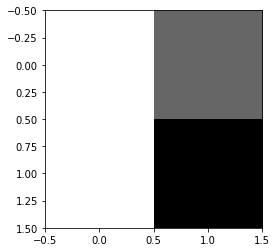

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
pred = np.argmax(cmodel.predict(x_test,100),axis=1)
pred
cm = confusion_matrix(yt,pred)
cm
plt.imshow(cm, cmap='binary')

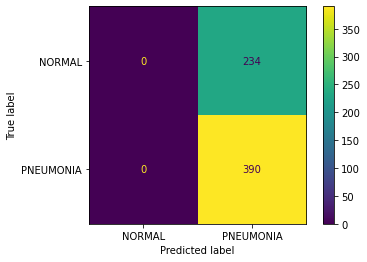

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['NORMAL','PNEUMONIA'])


# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot()

plt.show()

In [29]:
from sklearn.metrics import classification_report
print(classification_report(yt, pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
